In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from collections import Counter
import contractions
from spellchecker import SpellChecker
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
warnings.filterwarnings('ignore')

In [2]:
sentiment_df=pd.read_csv("../data/sentiment_train",delimiter="\t")

In [3]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7086 entries, 0 to 7085
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  7086 non-null   int64 
 1   text       7086 non-null   object
dtypes: int64(1), object(1)
memory usage: 110.8+ KB


In [4]:
sentiment_df.head(5)

,sentiment,text
0,1,The Da Vinci Code book is just awesome.
1,1,this was the first clive cussler i've ever rea...
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly did...


In [5]:
sentiment_df.describe(include='all')

,sentiment,text
count,7086.000000,7086
unique,NaN,1410
top,NaN,I love Harry Potter.
freq,NaN,167
mean,0.563788,NaN
std,0.495949,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,1.000000,NaN
75%,1.000000,NaN


<h1><span style="color:red"> Step1:- </span> </h1> <h3> <b>EDA</b> (Preporcessing and Visualization) </h3> Remove numbers ,space and non word characters from beginning of each text.

In [6]:
sentiment_df["text"] = sentiment_df["text"].str.lower()

In [7]:
unique_sentiments=sentiment_df['sentiment'].unique()
for sentiment in unique_sentiments:
    print(sentiment)

1
0


In [8]:
sentiment_df_preprocessed=sentiment_df.drop_duplicates().dropna()

In [9]:
sentiment_df_preprocessed.shape[0]

1351

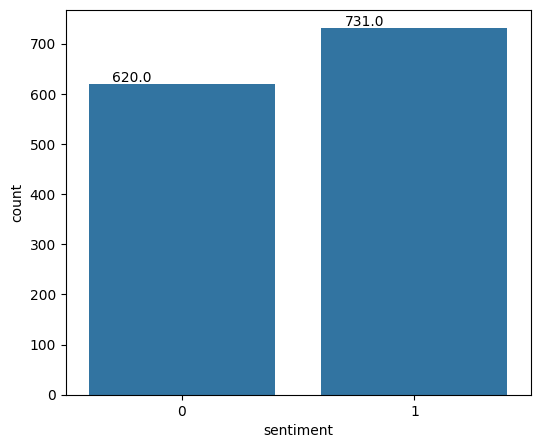

In [10]:
plt.figure(figsize=(6,5))
ax=sns.countplot(x='sentiment',data=sentiment_df_preprocessed);
for p in ax.patches:
    ax.annotate(p.get_height(),(p.get_x()+0.1,p.get_height()+5))

In [11]:
def remove_emoticons(text):
    # Define a regular expression pattern to match emoticons
    emoticon_pattern = re.compile(u'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+', flags=re.UNICODE)
    text_without_emoticon = re.sub(emoticon_pattern, '', text)
    
    return text_without_emoticon

def text_preprocess(text):
    stripped_text = text.strip()
    # Replace special characters with "special_character" except "&" with "and"
    converted_text1 = stripped_text.replace('&', 'and')
    # Keep only words, space and apostrophe
    converted_text2 = re.sub(r'[^a-z\s\']', '', converted_text1)
    # Remove multiple consecutive spaces and keep only one
    converted_text3 = re.sub(r'\s+', ' ', converted_text2)
    
    return converted_text3

# Apply all the preprocessing steps
sentiment_df_preprocessed['text'] = sentiment_df_preprocessed['text'].apply(remove_emoticons).apply(text_preprocess)

Lets consider each word as a feature, each sentence (all called as record and document) as bag of words. All documents is called corpus.

<h1><span style="color:red"> Step2:- </span> </h1> <h3> The first step creating BoW is to create a dictionary of all words used in the corpus.</h3> In this step we will not worry about grammar and only occurrence of the word is captured.

Convert each document to a vector that represents words available in the document. There are three ways to do that<br> <ol><li><b><span style="color:blue">Count Vector Model-></span></b> count the occurrence of each word in the document.</li><li><b><span style="color:blue">Term Frequency Vector Model-></span></b> the frequency of each word(term) in the document. that means number of occurrences of that word divided by total number of words</li><li><b><span style="color:blue">Term Frequency-Inverse DocumentFrequency (TF-IDF) Model-></span></b> Shows the importance of a word to a document. It increases proportionally to the number of times a word apprears in the document and is reduced by the frequency of the word present in the corpus. </li></ol>

In [12]:
countVectorizer=CountVectorizer()
#learn the vocabulary from the input data & tokenizes input data based on whitespace
# or punctuation and constructs a mapping between tokens and integer indices
featureVector=countVectorizer.fit(sentiment_df_preprocessed.text) 
features=featureVector.get_feature_names_out()

In [13]:
len(features) #total no of unique words in the corpus are 2132

2142

In [14]:
sentiment_features=countVectorizer.transform(sentiment_df_preprocessed.text) #transform method converts each text document into a vector representation, where each element of the vector corresponds to the frequency of the corresponding token in the vocabulary.
type(sentiment_features)

scipy.sparse._csr.csr_matrix

In [15]:
sentiment_features.shape

(1351, 2142)

In [16]:
sentiment_features.getnnz() #To count the total non zero elements in the sparse matrix

13573

In [17]:
sentiment_features_df=pd.DataFrame(sentiment_features.toarray())
sentiment_features_df.columns=features

We can see many numeric values. we need to understand whether they are impor

Lets try to analyze frequency of features using histogram

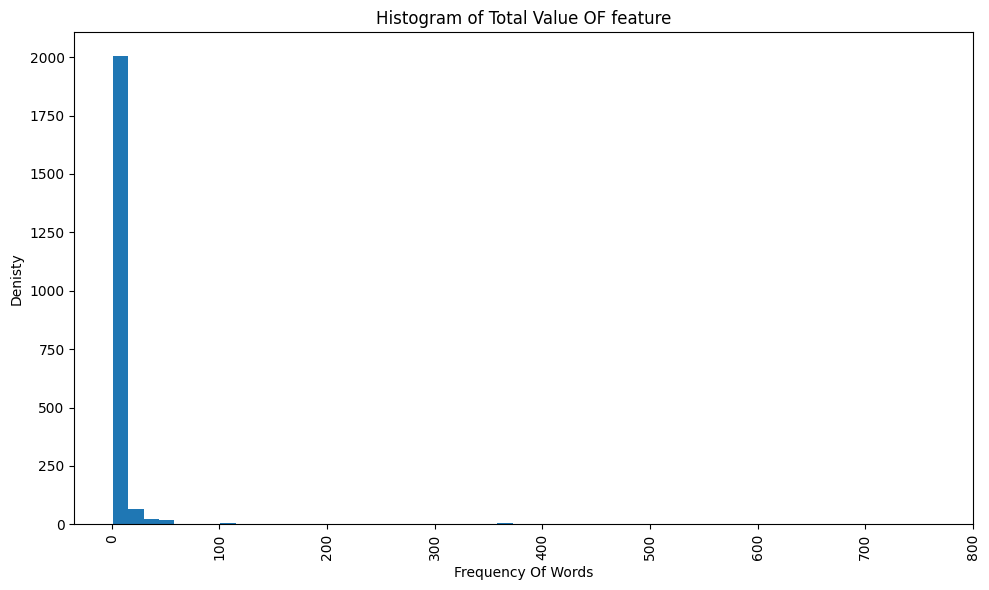

In [18]:
feature_sums=sentiment_features_df.sum()
bin_edges=np.arange(0,feature_sums.max()+100,100)
plt.figure(figsize=(10,6))
plt.hist(feature_sums,bins=50)
plt.xlabel("Frequency Of Words")
plt.ylabel("Denisty")
plt.title('Histogram of Total Value OF feature')
plt.xticks(bin_edges,rotation=90)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()
plt.show()

We can see large number of features have very rare occurrences

In [19]:
sentiment_features_counter_df=pd.DataFrame(dict(features=features,counts=feature_sums))

In [20]:
sentiment_features_counter_df.reset_index(drop=True,inplace=True)

In [21]:
sentiment_features_counter_df.sort_values('counts',ascending=False)[0:15]

,features,counts
1867,the,715
66,and,409
2014,vinci,368
432,da,366
338,code,362
242,brokeback,362
1262,mountain,359
1465,potter,354
858,harry,353
1013,is,312


We can see many stop words (the,is,was, and etc.) are most frequented words. As they are irrelevant determining the sentiment of the document we can remove them.

In [22]:
my_stop_words=text.ENGLISH_STOP_WORDS
#check what are these stop words
print("Few stop words->",list(my_stop_words)[0:10])

Few stop words-> ['nine', 'full', 'part', 'two', 'amongst', 'mill', 'until', 'system', 'others', 'get']


Convert text to lowercase
Remove special characters, punctuation and unwanted symbols
Handling Numbers
Spell Correction
Handling Contraction
Handling Emoticon
Tokenization
Remove Stop words
Stemming or Lemmatization